# HW 1: Futures Spread Dynamics

The last two digits of my student id is 86 and I chose to explore 8 - CL versus NG.

In [81]:
from pathlib import Path
import pandas as pd
import databento as db
from plotnine import *
from concurrent.futures import ThreadPoolExecutor
import numpy as np

### Data Load

We use CME 1-minute futures data for Crude Oil (CL) and Natural Gas (NG) over the trading days December 12–19, 2025. For each future, we identify the front-month and second-month contracts as the two expirations with the largest number of observations (CLG6/CLH6 for CL and NGF26/NGG26 for NG), forward-filling prices where necessary. We then construct second-minus-front-month spreads as $(X_t - W_t)$ for CL and $(Z_t - Y_t)$ for NG.


In [ ]:
DATA_DIR = Path(r"C:\Users\15126\Desktop\Chicago\Winter\qts\hw\CME_1minute_Dec_2025")
spreads_csv = Path("spreads.csv")
files = ["20251212","20251215","20251216","20251217","20251218","20251219"]
keep_symbols = {"CLG6", "CLH6", "NGF26", "NGG26"}

def read_file(d):
    """Read and process a single file"""
    f = DATA_DIR / f"glbx-mdp3-{d}.ohlcv-1m.dbn.zst"
    df = db.DBNStore.from_file(f).to_df()
    
    df = df[df["symbol"].isin(keep_symbols)][["symbol", "close"]].copy()
    df["day"] = pd.Timestamp(d).date()
    df["minute"] = df.groupby("symbol", sort=False).cumcount() + 1
    
    return df

if not spreads_csv.exists():

    with ThreadPoolExecutor(max_workers=4) as executor:
        dfs = list(executor.map(read_file, files))
    df_all = pd.concat(dfs, ignore_index=True, copy=False)
    del dfs  
    

    wide = df_all.pivot(
        index=["day", "minute"], 
        columns="symbol", 
        values="close"
    )
    del df_all  
    
    wide = wide.groupby(level=0, group_keys=False).ffill()
    
    wide["CL_spread"] = wide["CLH6"].values - wide["CLG6"].values
    wide["NG_spread"] = wide["NGG26"].values - wide["NGF26"].values
    
    wide.to_csv(spreads_csv)
    del wide

In [80]:
df = pd.read_csv(spreads_csv, index_col=[0, 1])

### Crude Oil and Natural Gas Spreads Illustration (2025-12-12 to 2025-12-19)

- Crude Oil (red): CLH6 - CLG6 (Crude Oil February minus January contracts)

    - Highly volatile, ranging from -1.0 to +0.7, with significant intraday trending patterns, particularly active on December 15th, 17th, 18th, and 19th

- Natural Gas (teal): NGG26 - NGF26 (Natural Gas February minus January contracts)

    -  Relatively stable around -0.25 to -0.30, with minimal intraday variation and a consistent negative spread throughout

The relative difference in volatility suggests different market dynamics for crude oil versus natural gas calendar. 

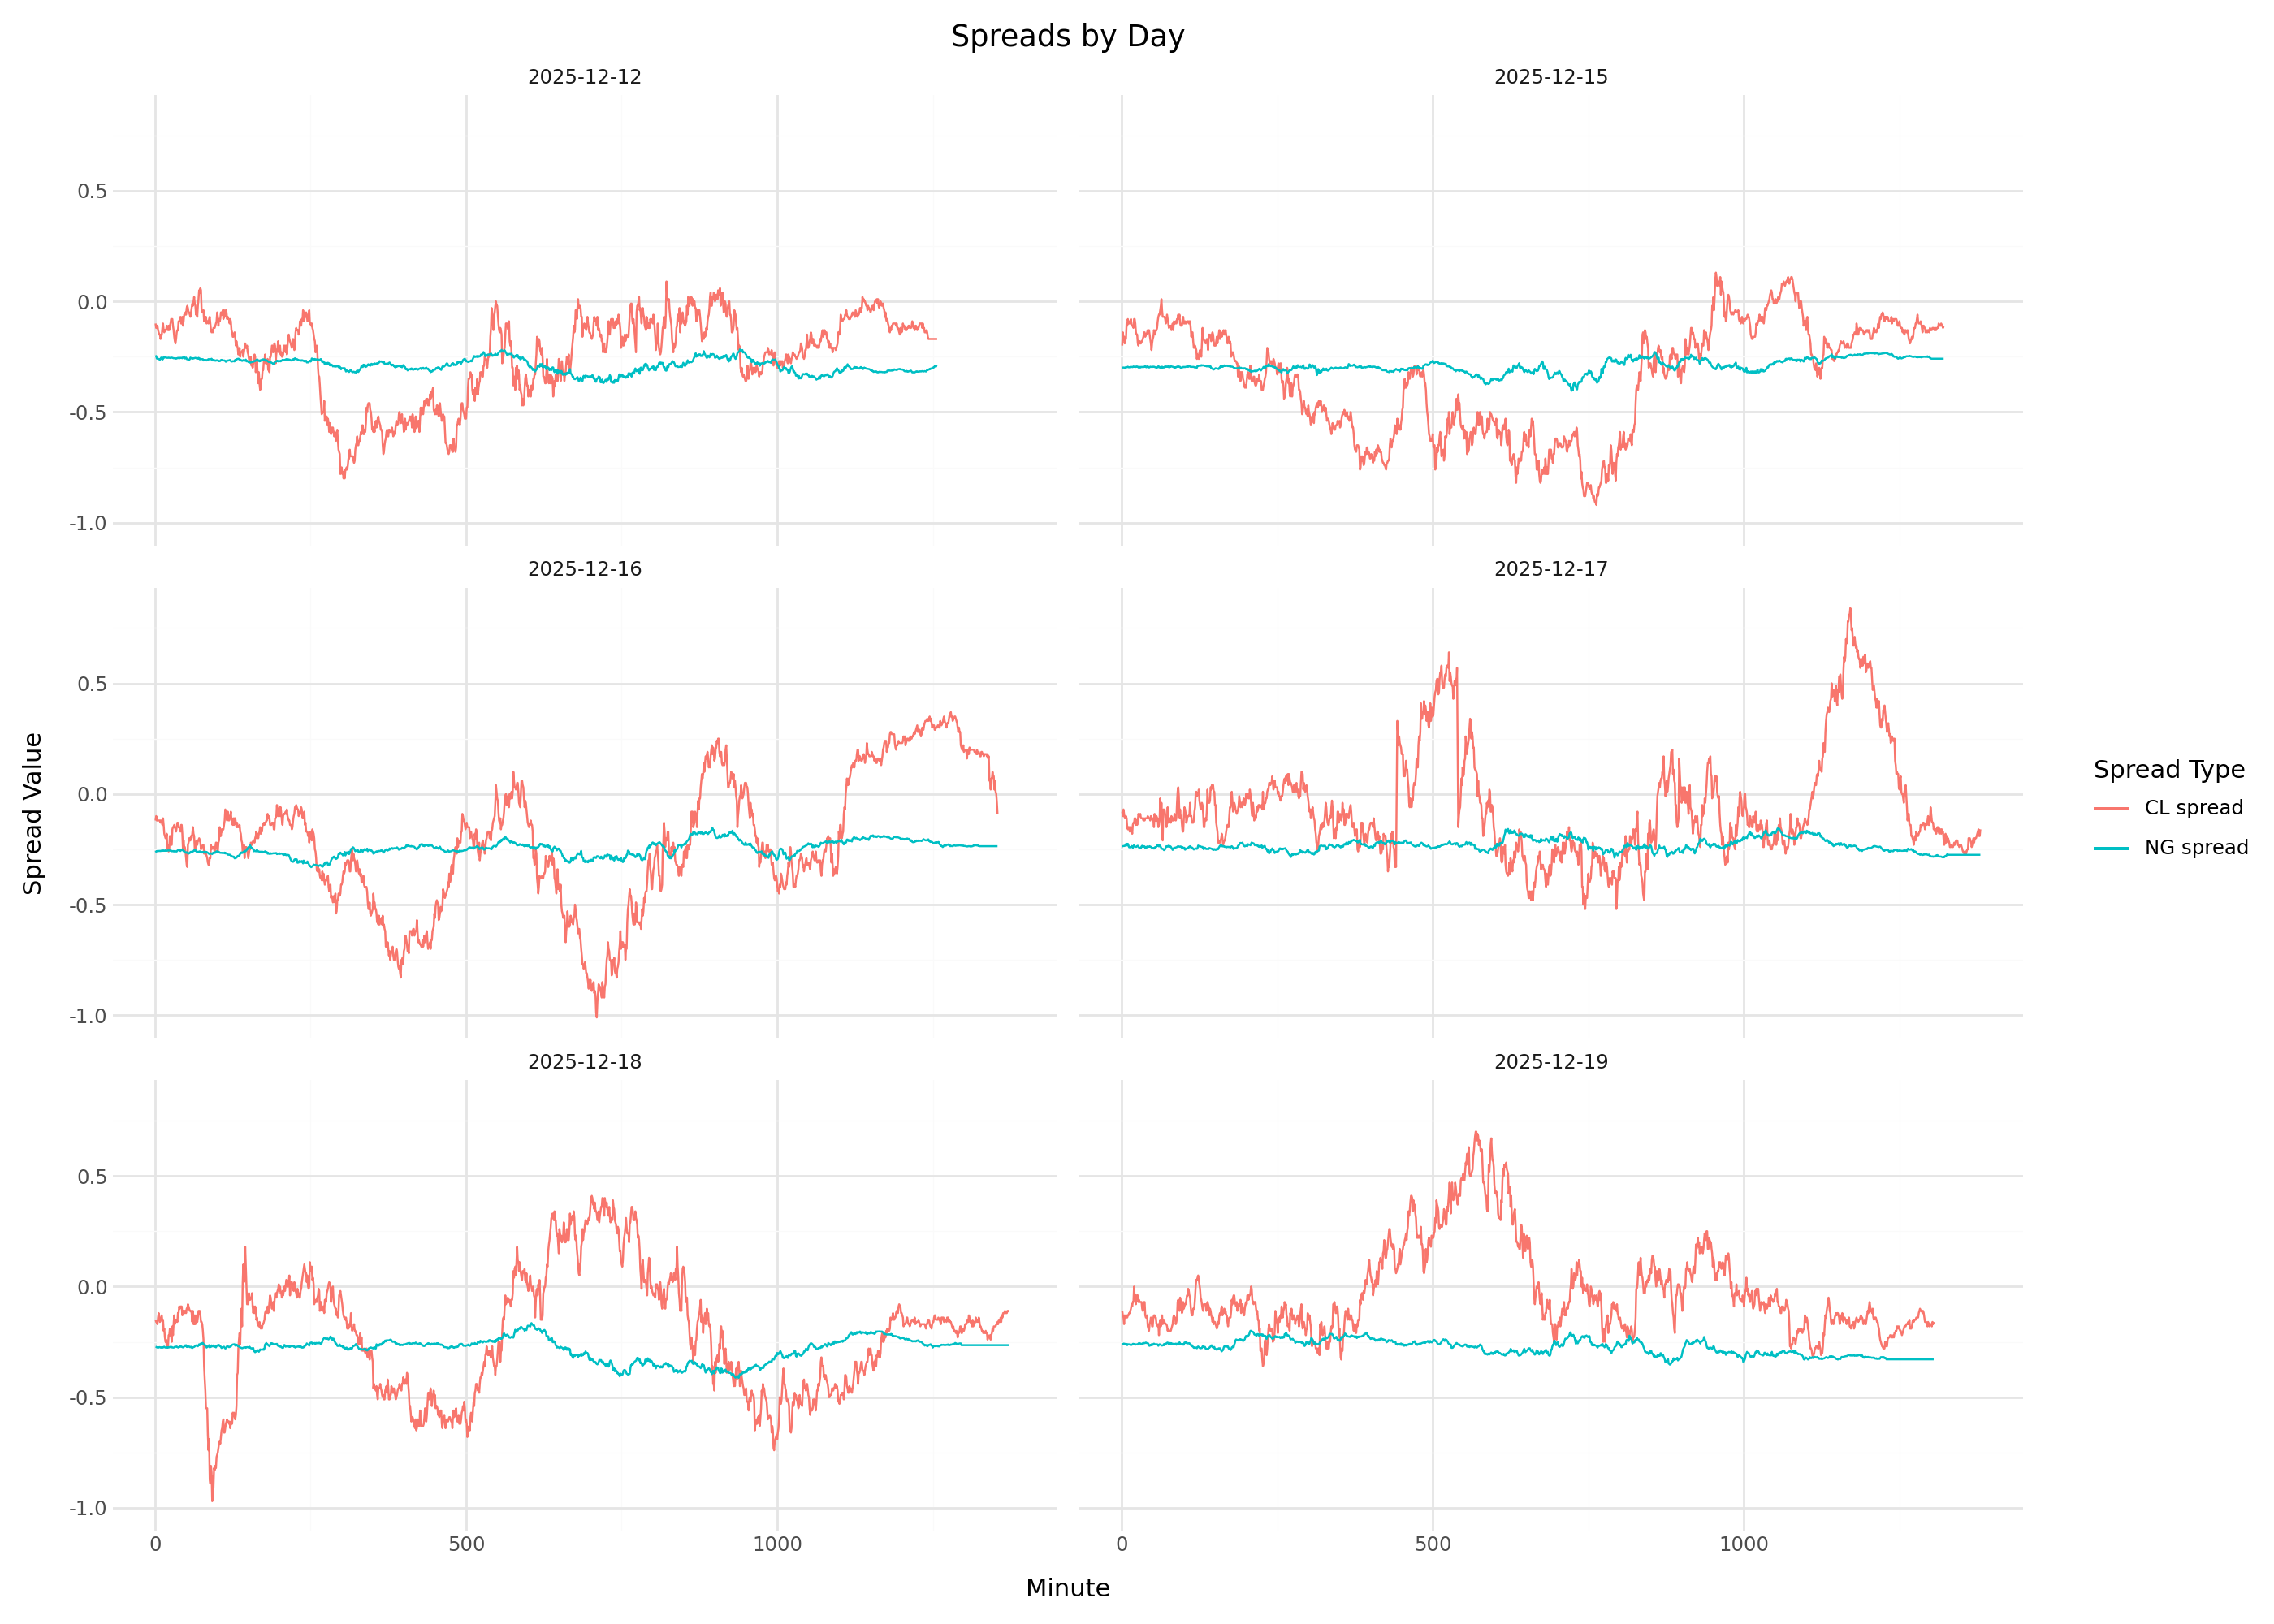

In [74]:
df_plot = df.reset_index()

spreads_long = df_plot[['day', 'minute', 'CL_spread', 'NG_spread']].melt(
    id_vars=['day', 'minute'],
    var_name='spread_type',
    value_name='spread_value'
)

spreads_long['spread_type'] = spreads_long['spread_type'].str.replace('_', ' ')

plot = (
    ggplot(spreads_long, aes(x='minute', y='spread_value', color='spread_type'))
    + geom_line(size=0.5)
    + facet_wrap('~day', ncol=2)
    + labs(title='Spreads by Day', x='Minute', y='Spread Value', color='Spread Type')
    + theme_minimal()
    + theme(figure_size=(14, 10))
)

plot

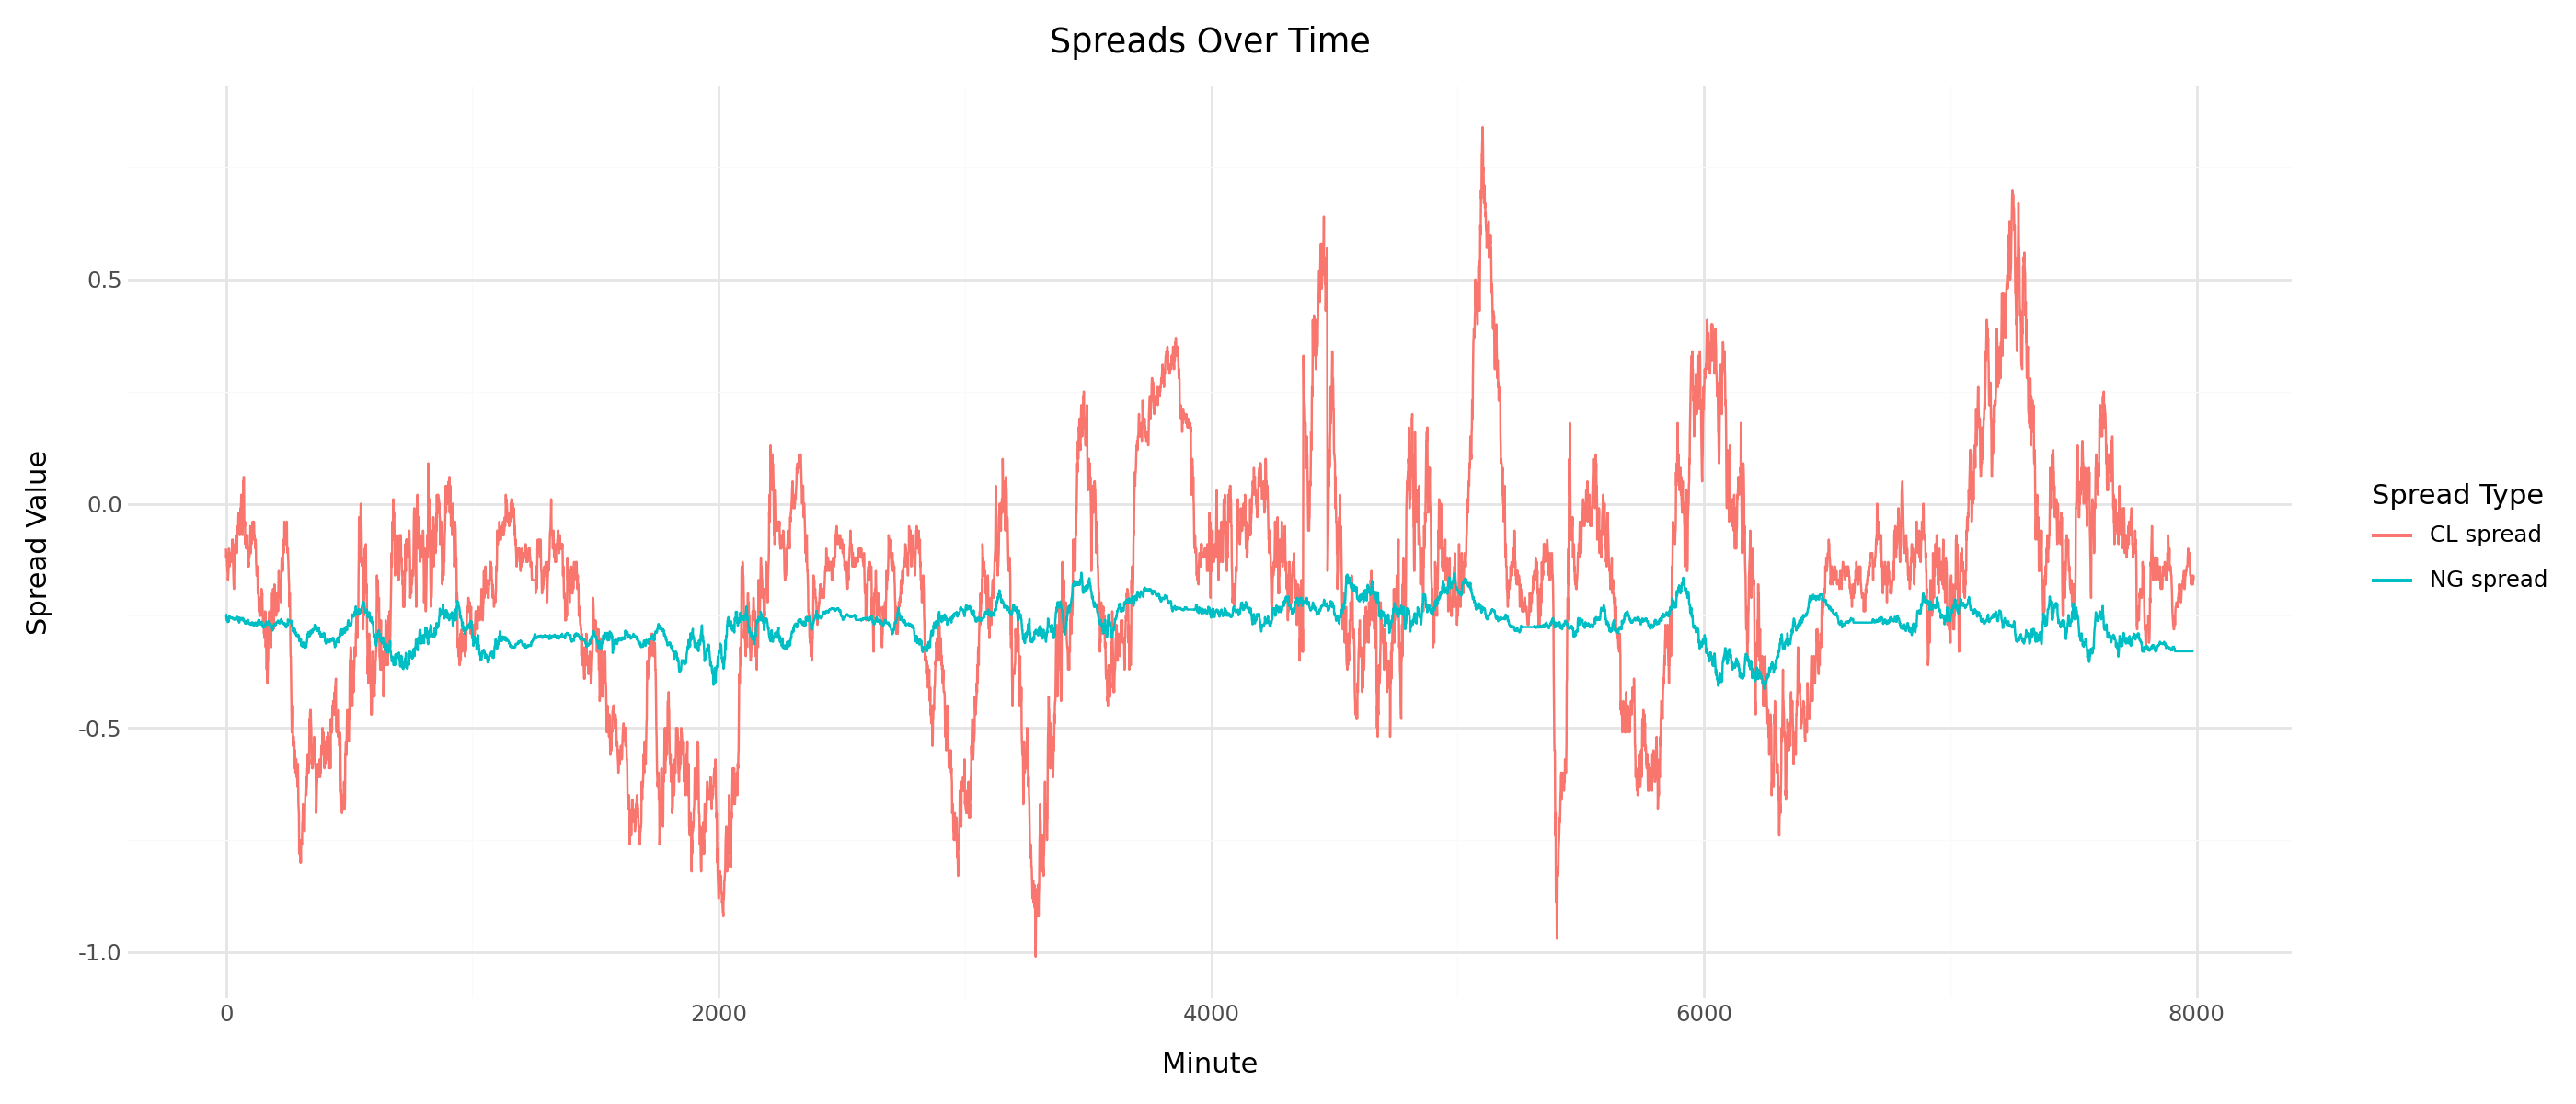

In [78]:
df_plot = df.reset_index()
df_plot['continuous_minute'] = range(len(df_plot))

spreads_long = df_plot[['continuous_minute', 'CL_spread', 'NG_spread']].melt(
    id_vars='continuous_minute',
    var_name='spread_type',
    value_name='spread_value'
)
spreads_long['spread_type'] = spreads_long['spread_type'].str.replace('_', ' ')

plot = (
    ggplot(spreads_long, aes(x='continuous_minute', y='spread_value', color='spread_type'))
    + geom_line(size=0.5)
    + labs(title='Spreads Over Time', x='Minute', y='Spread Value', color='Spread Type')
    + theme_minimal()
    + theme(figure_size=(14, 6))
)

plot

### Moving Average Analysis

For each window size $N \in \{60, 120, 180, 240, 300, 360\}$ minutes, we calculate the moving average of the spread $s_t^{(i)}$ at time $t$:

$$\text{MA}_N(s_t^{(i)}) = \frac{1}{N} \sum_{j=0}^{N-1} s_{t-j}^{(i)}$$

where:
- $s_t^{(i)}$ is the spread at time $t$ (either CL or NG)
- $N$ is the window size in minutes
- The moving average is computed separately for each trading day to avoid contamination across non-trading periods (weekends)

Note that groupby('day') ensures that the rolling window resets at the start of each trading day, preventing Friday data from influencing Monday calculations.

The deviation at time $t$ is the difference between the actual spread and its $N$-period moving average:

$$d_t^{(N)} = s_t^{(i)} - \text{MA}_N(s_t^{(i)})$$

This measures how far the current spread value deviates from its recent average trend.

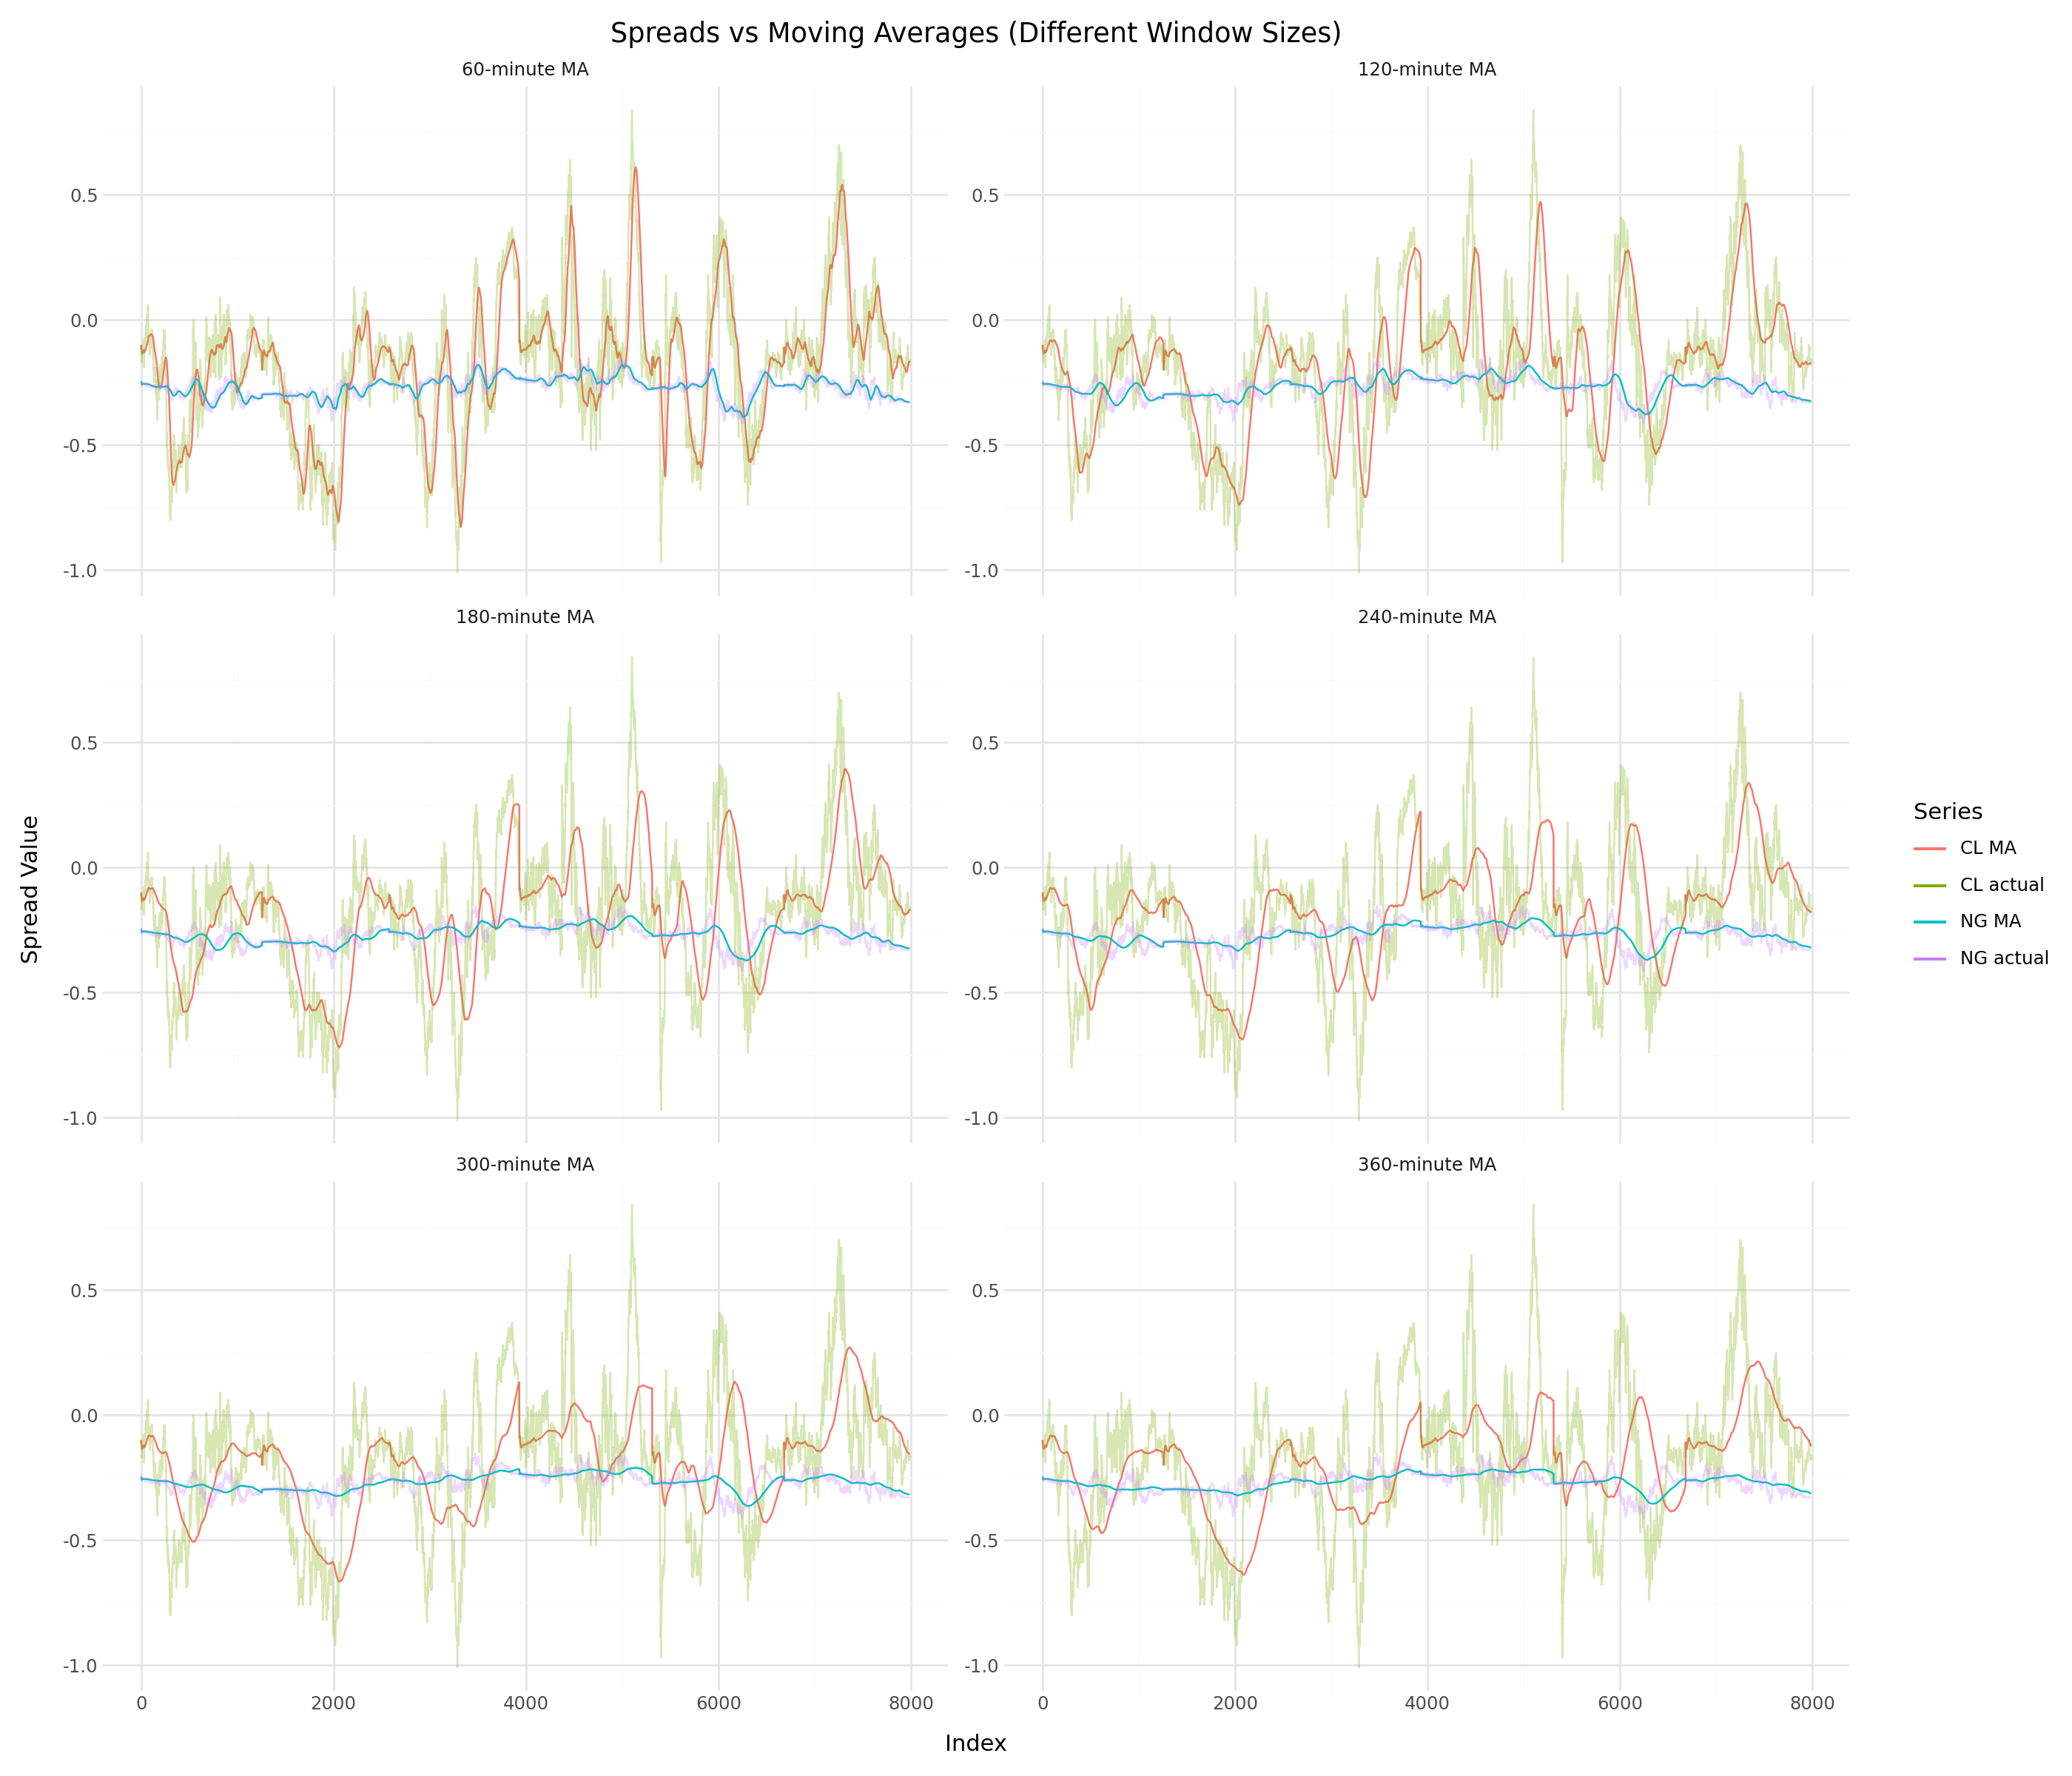

In [91]:
windows = [60, 120, 180, 240, 300 , 360]

for N in windows:
    df_plot[f'CL_MA_{N}'] = df_plot.groupby('day')['CL_spread'].transform(
        lambda x: x.rolling(window=N, min_periods=1).mean()
    )
    df_plot[f'NG_MA_{N}'] = df_plot.groupby('day')['NG_spread'].transform(
        lambda x: x.rolling(window=N, min_periods=1).mean()
    )

plot_data_list = []

for N in windows:
    temp_df = df_plot[['index', 'CL_spread', f'CL_MA_{N}', 'NG_spread', f'NG_MA_{N}']].copy()
    temp_df.columns = ['index', 'CL_actual', 'CL_MA', 'NG_actual', 'NG_MA']
    temp_df['window'] = f'{N}-minute MA'
    
    temp_long = temp_df.melt(id_vars=['index', 'window'], var_name='series', value_name='value')
    plot_data_list.append(temp_long)

plot_data = pd.concat(plot_data_list, ignore_index=True)

plot_data['series'] = plot_data['series'].str.replace('_', ' ')
plot_data['line_type'] = plot_data['series'].apply(lambda x: 'actual' if 'actual' in x else 'MA')

plot_data['window'] = pd.Categorical(
    plot_data['window'], 
    categories=[f'{N}-minute MA' for N in windows],
    ordered=True
)

plot = (
    ggplot(plot_data, aes(x='index', y='value', color='series', alpha='line_type'))
    + geom_line(size=0.5)
    + scale_alpha_manual(values={'actual': 0.3, 'MA': 1.0})
    + facet_wrap('~window', ncol=2, scales='free_y')
    + labs(title='Spreads vs Moving Averages (Different Window Sizes)', 
           x='Index', y='Spread Value', color='Series')
    + theme_minimal()
    + theme(figure_size=(14, 12))
    + guides(alpha=False)
)

plot

For each window size $N$ and each spread type (CL or NG), we compute:

**Mean deviation:**
$$\bar{d}^{(N)} = \frac{1}{T} \sum_{t=1}^{T} d_t^{(N)}$$

**Median deviation:**
$$\text{median}(d^{(N)}) = \text{50th percentile of } \{d_1^{(N)}, d_2^{(N)}, ..., d_T^{(N)}\}$$

**Standard deviation:**
$$\sigma(d^{(N)}) = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} (d_t^{(N)} - \bar{d}^{(N)})^2}$$

where $T$ is the total number of observations across all trading days.

In [95]:
for N in windows:
    df_plot[f'CL_dev_{N}'] = df_plot['CL_spread'] - df_plot[f'CL_MA_{N}']
    df_plot[f'NG_dev_{N}'] = df_plot['NG_spread'] - df_plot[f'NG_MA_{N}']

stats_results = []
for N in windows:
    stats_results.append({
        'N': N,
        'Spread': 'CL',
        'Median': df_plot[f'CL_dev_{N}'].median(),
        'Std': df_plot[f'CL_dev_{N}'].std(),
        'Mean': df_plot[f'CL_dev_{N}'].mean()
    })
    stats_results.append({
        'N': N,
        'Spread': 'NG',
        'Median': df_plot[f'NG_dev_{N}'].median(),
        'Std': df_plot[f'NG_dev_{N}'].std(),
        'Mean': df_plot[f'NG_dev_{N}'].mean()
    })

stats_df = pd.DataFrame(stats_results)
stats_df

,N,Spread,Median,Std,Mean
0,60,CL,0.005167,0.129199,0.000489
1,60,NG,-0.000617,0.019642,-0.000325
2,120,CL,0.000500,0.180831,0.001642
3,120,NG,-0.001100,0.026374,-0.000625
4,180,CL,-0.001351,0.214354,0.003880
5,180,NG,-0.001506,0.030370,-0.000746
6,240,CL,-0.002083,0.232408,0.006728
7,240,NG,-0.001211,0.032629,-0.000756
8,300,CL,-0.006500,0.239113,0.009173
9,300,NG,-0.001156,0.033568,-0.000648


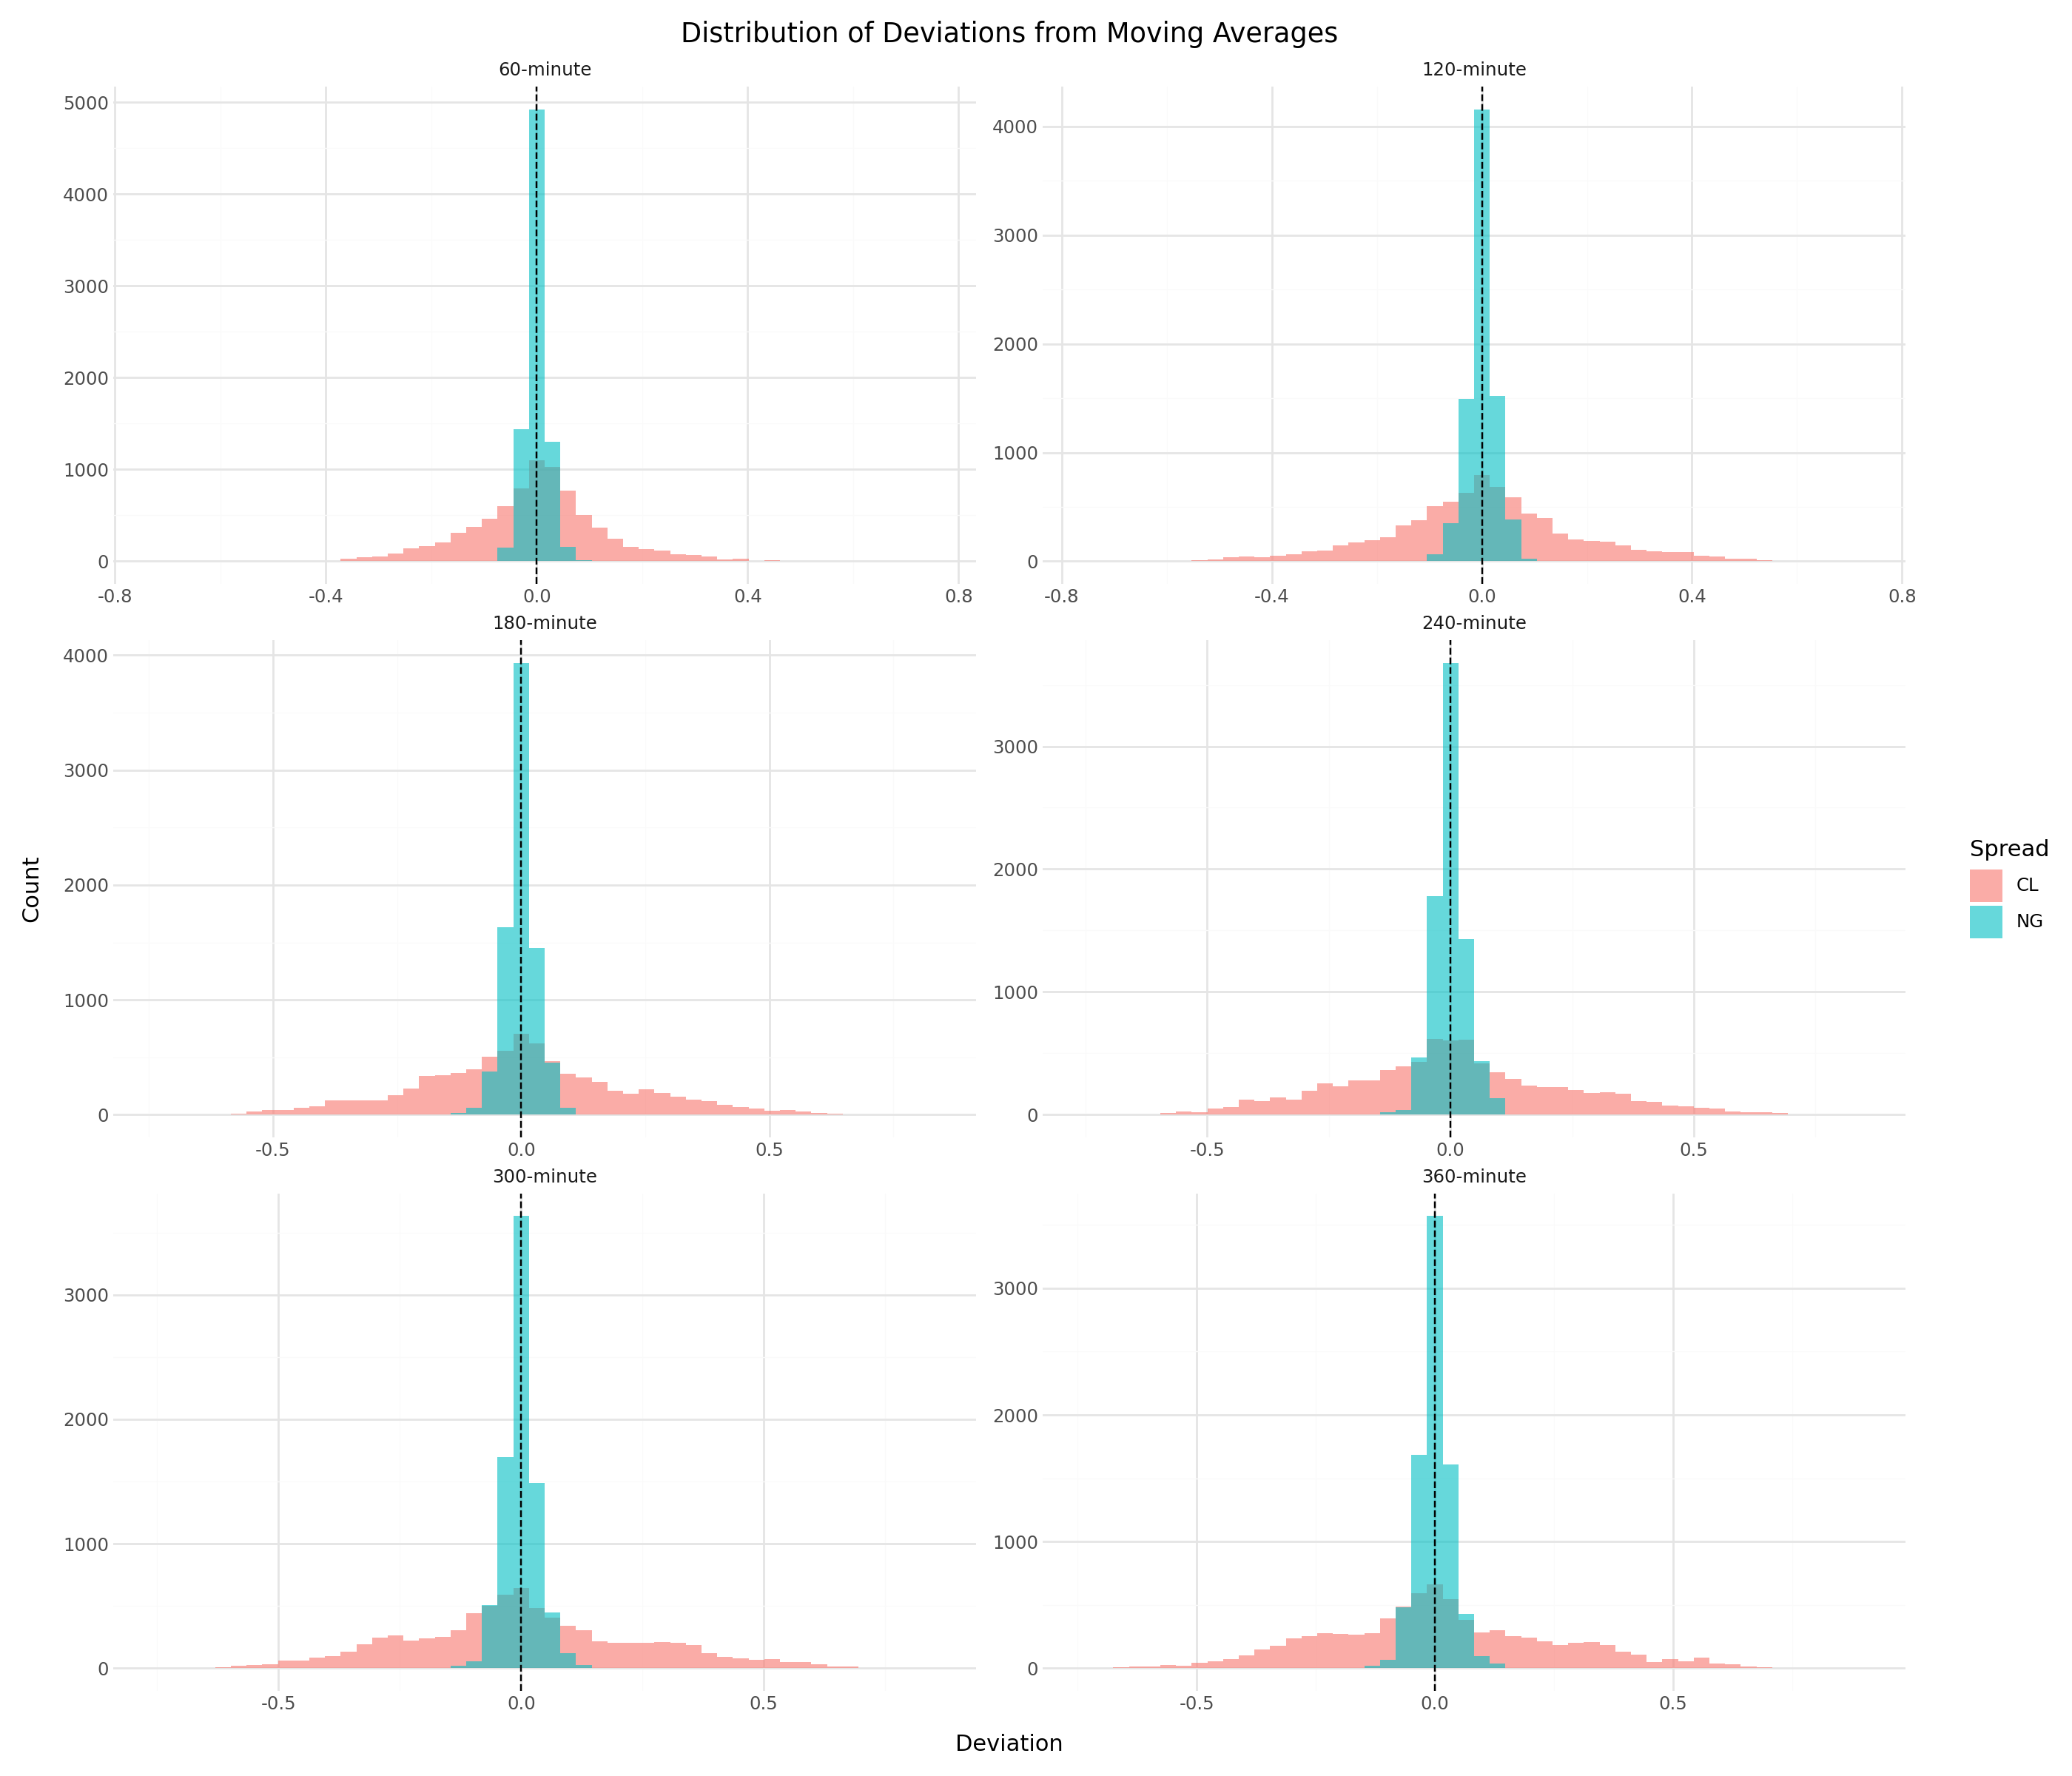

In [94]:
dev_plot_data_list = []
for N in windows:
    temp_df = df_plot[['index', f'CL_dev_{N}', f'NG_dev_{N}']].copy()
    temp_df.columns = ['index', 'CL', 'NG']
    temp_df['window'] = f'{N}-minute'
    temp_long = temp_df.melt(id_vars=['index', 'window'], var_name='spread', value_name='deviation')
    dev_plot_data_list.append(temp_long)

dev_plot_data = pd.concat(dev_plot_data_list, ignore_index=True)
dev_plot_data['window'] = pd.Categorical(
    dev_plot_data['window'],
    categories=[f'{N}-minute' for N in windows],
    ordered=True
)

dev_plot = (
    ggplot(dev_plot_data, aes(x='deviation', fill='spread'))
    + geom_histogram(bins=50, alpha=0.6, position='identity')
    + geom_vline(xintercept=0, linetype='dashed', color='black', size=0.5)
    + facet_wrap('~window', ncol=2, scales='free')
    + labs(title='Distribution of Deviations from Moving Averages', x='Deviation', y='Count', fill='Spread')
    + theme_minimal()
    + theme(figure_size=(14, 12))
)

dev_plot

**Natural Gas Spread (Teal):**  
The NG spread exhibits a near-normal distribution with low dispersion (σ ≈ 0.02–0.03), tightly centered around zero. The distribution is sharply peaked, with the vast majority of observations contained within ±0.1 of the mean, indicating limited variability and strong mean-reverting behavior.

**Crude Oil Spread (Red):**  
In contrast, the CL spread displays a substantially wider near-normal distribution (σ ≈ 0.13–0.24), approximately 6–7 times more dispersed than NG. The distribution features noticeably heavier tails, with values extending to ±0.8 or beyond, reflecting higher volatility and larger deviations from the mean.

**Comparative Observations:**  
Both spreads are symmetric and centered around zero, suggesting balanced oscillation around their respective moving averages rather than persistent directional bias. The relative scale difference between NG and CL remains stable across all window lengths (60–360 minutes), implying a structural volatility distinction rather than a window-dependent effect. While NG preserves a consistent distributional shape across time horizons, CL demonstrates a mild increase in dispersion at longer windows, consistent with volatility accumulation over extended intervals.


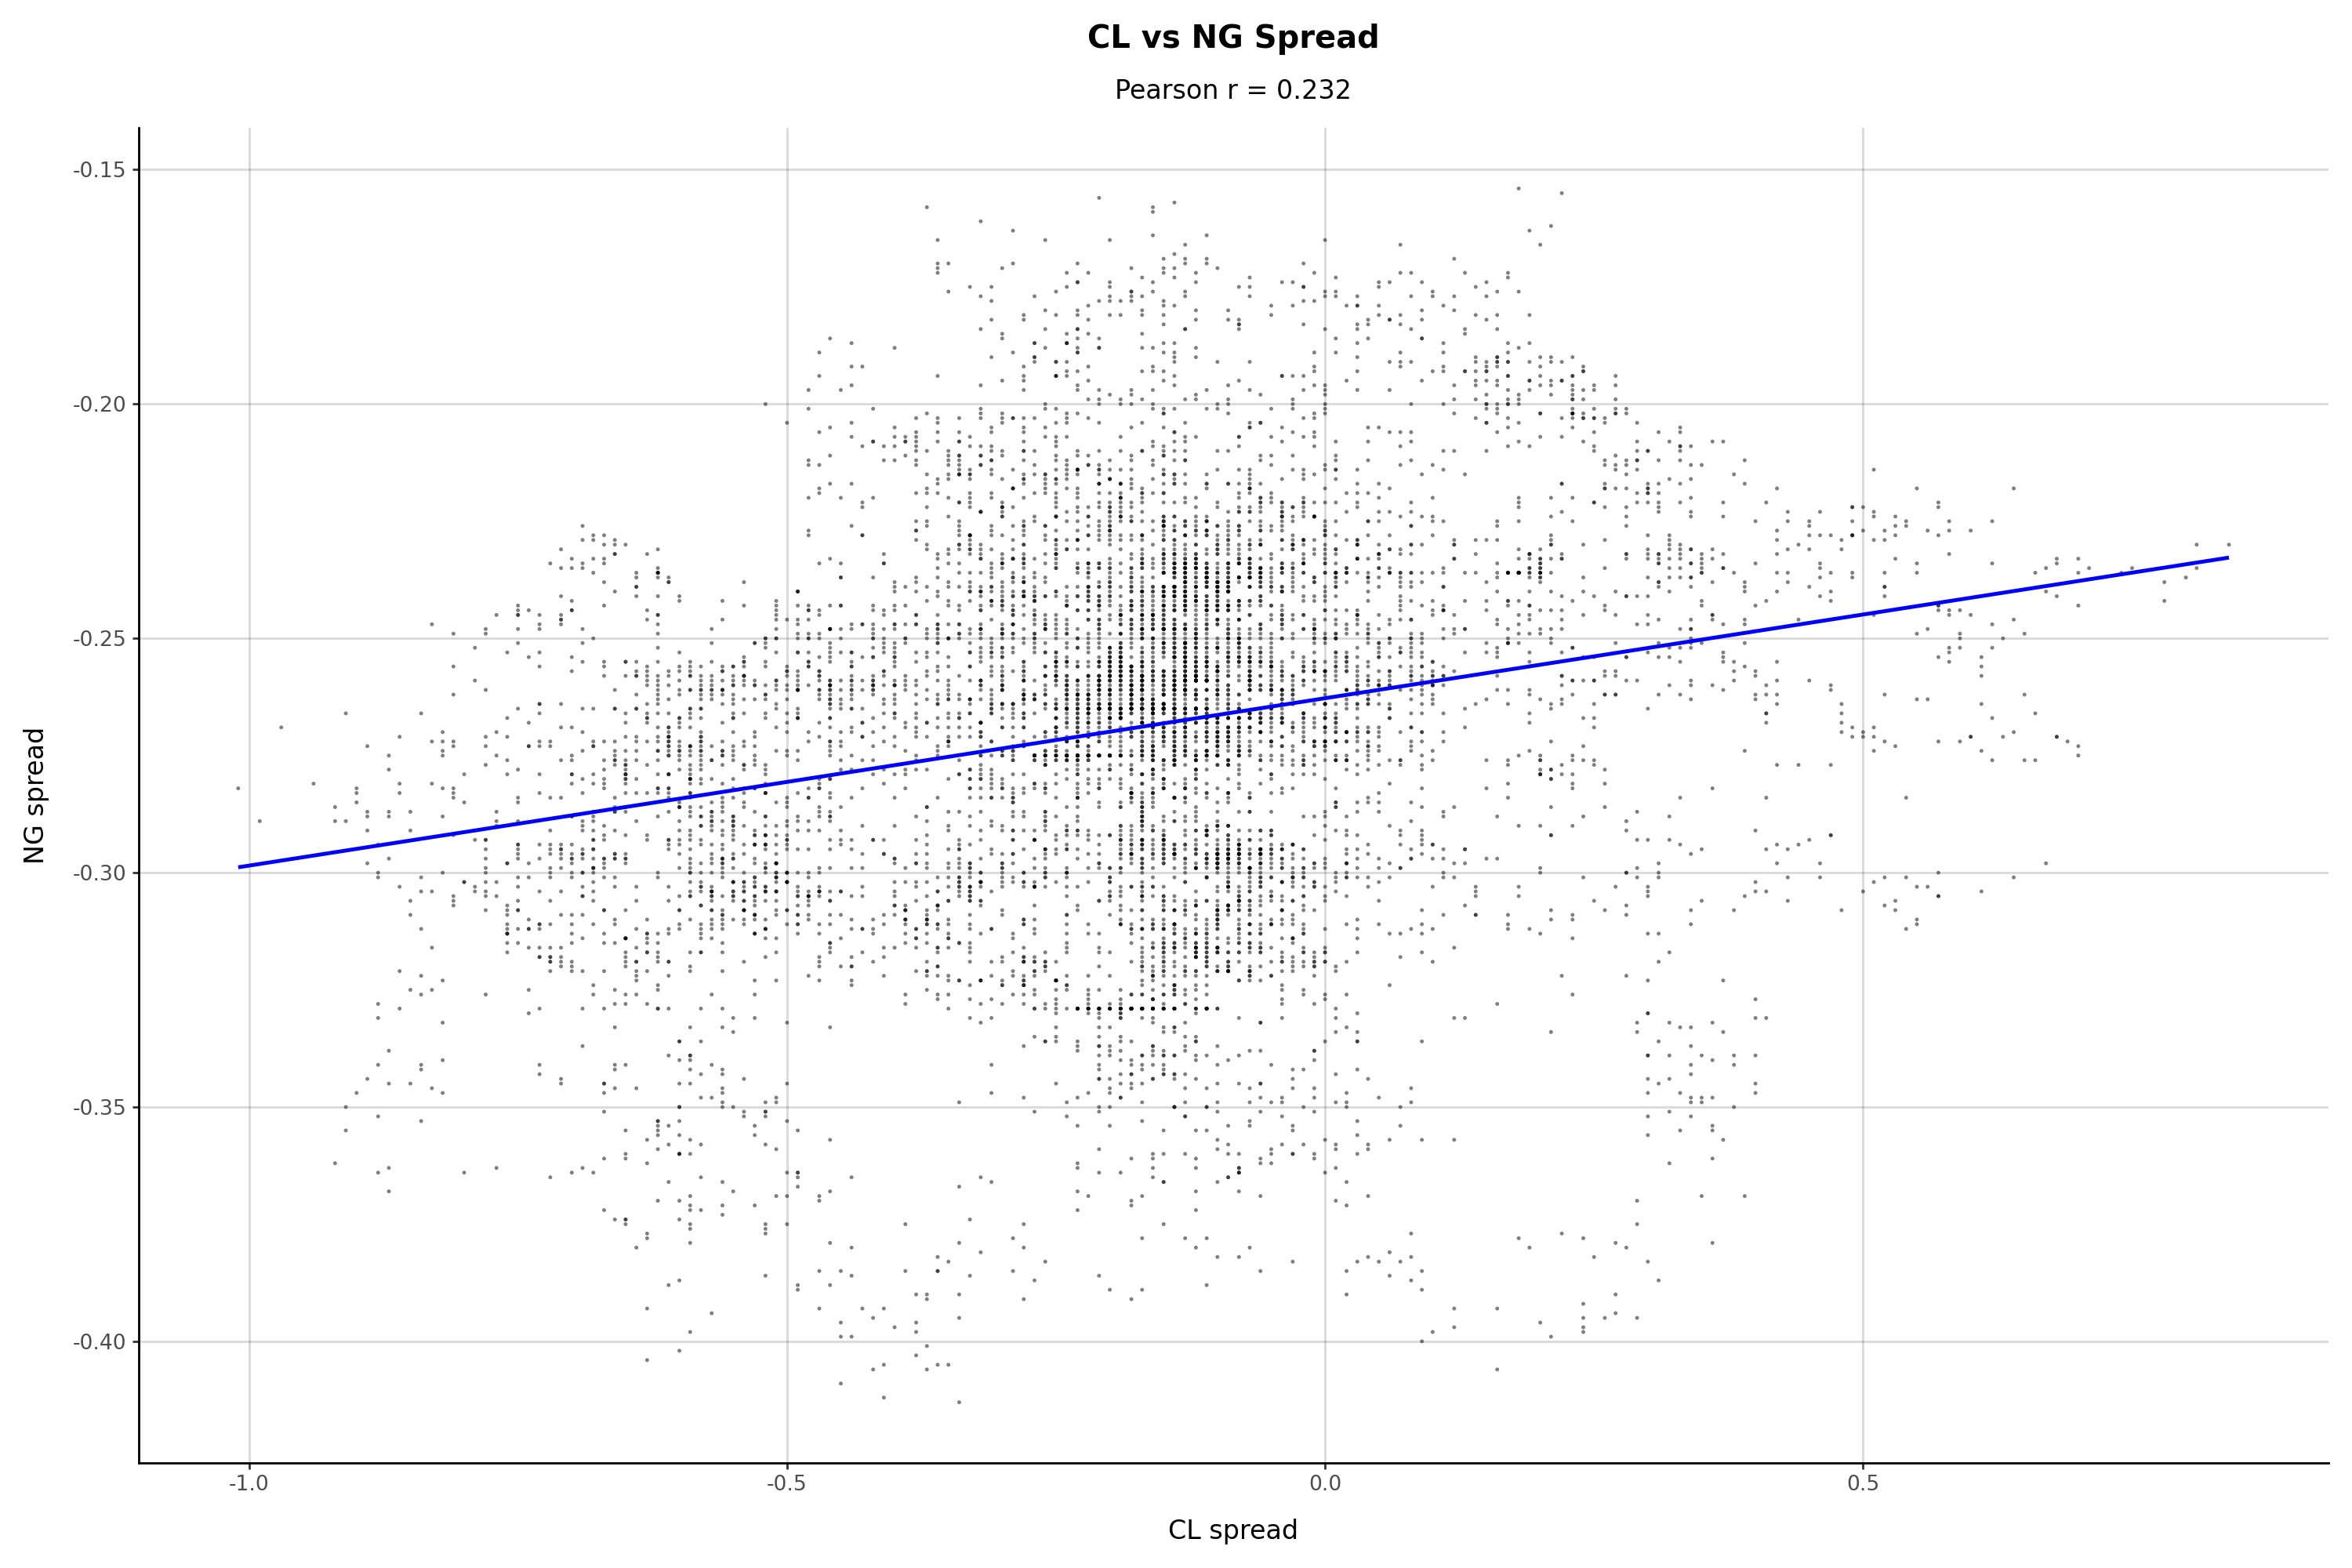

In [112]:
corr = df_plot['CL_spread'].corr(df_plot['NG_spread'])

scatter_plot = (
    ggplot(df_plot, aes('CL_spread', 'NG_spread'))
    + geom_point(alpha=0.5, size=1.0, stroke=0)
    + geom_smooth(method='lm', se=False, size=1.0, color='blue')
    + labs(
        title='CL vs NG Spread',
        subtitle=f'Pearson r = {corr:.3f}',
        x='CL spread',
        y='NG spread'
    )
    + theme_classic(base_size=12)
    + theme(
        figure_size=(15.0, 10.0),
        plot_title=element_text(weight='bold', ha='center'),
        plot_subtitle=element_text(ha='center'),
        panel_grid_major=element_line(alpha=0.15),
        panel_grid_minor=element_blank()
    )
)

scatter_plot

In [113]:
for N in windows:
    corr = df_plot[f'CL_dev_{N}'].corr(df_plot[f'NG_dev_{N}'])
    print(f"Deviation correlation (N={N}): {corr:.4f}")

Deviation correlation (N=60): 0.0716
Deviation correlation (N=120): 0.0963
Deviation correlation (N=180): 0.0947
Deviation correlation (N=240): 0.0839
Deviation correlation (N=300): 0.0773
Deviation correlation (N=360): 0.0679


The correlations are very small (around 0.07–0.10), indicating that CL and NG deviations from their averages barely move together. This pattern is consistent across all window sizes (60–360), showing that changing the time window does not strengthen the relationship. Overall, CL and NG deviations behave mostly independently in the short run.
